In [1]:
import pickle
from os.path import exists 
import pandas as pd
import plotly.express as px
from feature_engine.selection import DropCorrelatedFeatures

from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_evaluations, plot_convergence, plot_objective
from skopt.utils import dump, load

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


from catboost import CatBoostClassifier
task = "cyp2c19"

# Data

## Molecular Fingerprints

Machine learning models almost always take arrays of numbers as their inputs. If we want to process molecules with them, we somehow need to represent each molecule as one or more arrays of numbers.

Many (but not all) types of models require their inputs to have a fixed size. This can be a challenge for molecules, since different molecules have different numbers of atoms. If we want to use these types of models, we somehow need to represent variable sized molecules with fixed sized arrays.

Fingerprints are designed to address these problems. A fingerprint is a fixed length array, where different elements indicate the presence of different features in the molecule. If two molecules have similar fingerprints, that indicates they contain many of the same features, and therefore will likely have similar chemistry.

RDKit supports a particular type of fingerprint called an "Extended Connectivity Fingerprint", or "ECFP" for short. They also are sometimes called "circular fingerprints". The ECFP algorithm begins by classifying atoms based only on their direct properties and bonds. Each unique pattern is a feature. For example, "carbon atom bonded to two hydrogens and two heavy atoms" would be a feature, and a particular element of the fingerprint is set to 1 for any molecule that contains that feature. It then iteratively identifies new features by looking at larger circular neighborhoods. One specific feature bonded to two other specific features becomes a higher level feature, and the corresponding element is set for any molecule that contains it. This continues for a fixed number of iterations, most often two.

source: [https://www.kaggle.com/code/shivanshuman/molecular-fingerprints]

## Loading the Dataset + Data Cleaning

In terms of data cleaning the following steps are performed:

- Normalization of smiles strings before calculating descriptors and fingerprints
  - Normalization includes the removal of metals in the molecule (<span style="color:cyan">TODO</span> Why?)
- Removal of small molecules
  - For example: 
    - Molecules consisting of a single atom (<span style="color:cyan">TODO</span> Why?)
    - Molecules that are metals
- Removing of NaN values by either removing the corresponding column or row. 
  - For molecular descriptors it doesn't make much sense to fill missing values with some default value or mean of the existing values


In the first iteration we will focus on using the Morgan fingerprints. If there is time later we will explore other fingerprints and compare. 

In [2]:
data = data_preprocessing(task)
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)
data = select_druglike_molecules(data)
# data = remove_small_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

data

Dataset already exists, returning data/cyp2c19/raw_dataset.csv.
Numbe of molecules before druglikeliness selection: 12665
Numbe of druglike molecules: 12210


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,6602638.0,11.609395,0.039701,11.609395,0.039701,0.906872,309.841,285.649,...,0,0,0,0,0,0,0,0,0,0
1,1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,644675.0,12.610408,-3.973681,12.610408,0.072387,0.720977,355.418,346.346,...,0,0,0,0,0,0,0,0,0,0
2,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,644851.0,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0,0,0,0,0,0,0,0,0,0
3,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,644890.0,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,...,0,0,0,0,0,0,0,0,0,0
4,1,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,644968.0,12.040635,-0.208718,12.040635,0.006714,0.728361,324.344,308.216,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12660,0,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,16758814.0,12.346902,-0.801800,12.346902,0.024123,0.682518,263.293,246.157,...,0,0,0,0,0,0,0,0,0,0
12661,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
12662,1,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,16758817.0,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0,0,0,0,0,0,0,0,0,0
12663,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


### Remove missing values 
Since less than 1% of molecules have missing values we simply remove those molecules since using a default value doesn't make much sense for the shown descriptors.

In [3]:
data_nan = extract_null(data)
print(
    f"There are {data_nan.shape[0]} ({data_nan.shape[0]/data.shape[0]*100:.2f}%) molecules and {data_nan.shape[1]-3} descriptors with missing values."
)
data_nan

There are 35 (0.29%) molecules and 12 descriptors with missing values.


,Drug,Drug_ID,Y,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
3855,O=[As](O)(O)c1ccc([As](=O)(O)O)cc1,224250.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3856,O=S(=O)(Nc1nccs1)c1ccc([As](=O)(O)O)cc1,224267.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3857,O=C(O)CNC(=O)c1ccc([As](=O)(O)O)cc1,224270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3858,O=[As](O)(O)c1ccc(N=Nc2ccc(O)cc2)cc1,224279.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3859,NC(=O)c1ccc(C(=O)Nc2ccc([As](=O)(O)O)cc2)cc1,224295.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3863,NC(=O)Nc1cc([As](=O)(O)O)cc(I)c1O,224575.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3879,NS(=O)(=O)Cc1ccc([As](=O)(O)O)cc1,224907.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3880,O=C(O)[C@@H](O)c1ccc([As](=O)(O)O)cc1,3246047.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3881,O=S(=O)(NCCO)c1ccc([Sb](=O)(O)O)cc1,224913.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3882,O=C(O)/C=C\c1cccc([Sb](=O)(O)O)c1,5771529.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data = data.drop(data_nan.index)
data.shape

(12175, 2260)

### Train-Validation-Test split


In [5]:
# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))

Splitting the data into 70.00% training, 10.00% training, and 20.00% testing.


In [6]:
# The descriptors include discrete and continuous data, distinguished by their dtype.

feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Unique Datatypes: {dtype('int32'), dtype('int64'), dtype('float64')}


## Dataset Exoploration

In [7]:
datasets["train"].describe()

,Y,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,...,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.00000,8522.000000,8522.000000,8522.000000,8522.000000
mean,0.461981,11.222147,-0.825236,11.222147,0.200832,0.629437,342.136913,322.791049,341.760127,126.033091,...,0.013964,0.003051,0.015020,0.007627,0.024290,0.00927,0.013612,0.006102,0.010796,0.004224
std,0.498582,2.693377,1.439234,2.693377,0.224219,0.174060,85.287027,81.294685,85.183894,31.633750,...,0.117348,0.055154,0.121639,0.087006,0.153957,0.09584,0.115880,0.077880,0.103346,0.064861
min,0.000000,0.000000,-7.603763,0.000000,0.000000,0.086171,17.031000,14.007000,17.026549,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.903072,-0.965024,10.903072,0.049009,0.501267,287.751000,270.226000,287.169202,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,12.236159,-0.372411,12.236159,0.125293,0.647325,342.348500,323.226000,342.009207,126.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,12.869220,-0.041564,12.869220,0.248257,0.776694,399.537250,378.256000,399.171183,146.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,17.398044,3.500000,17.398044,3.500000,0.946895,776.872000,765.784000,776.686700,292.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


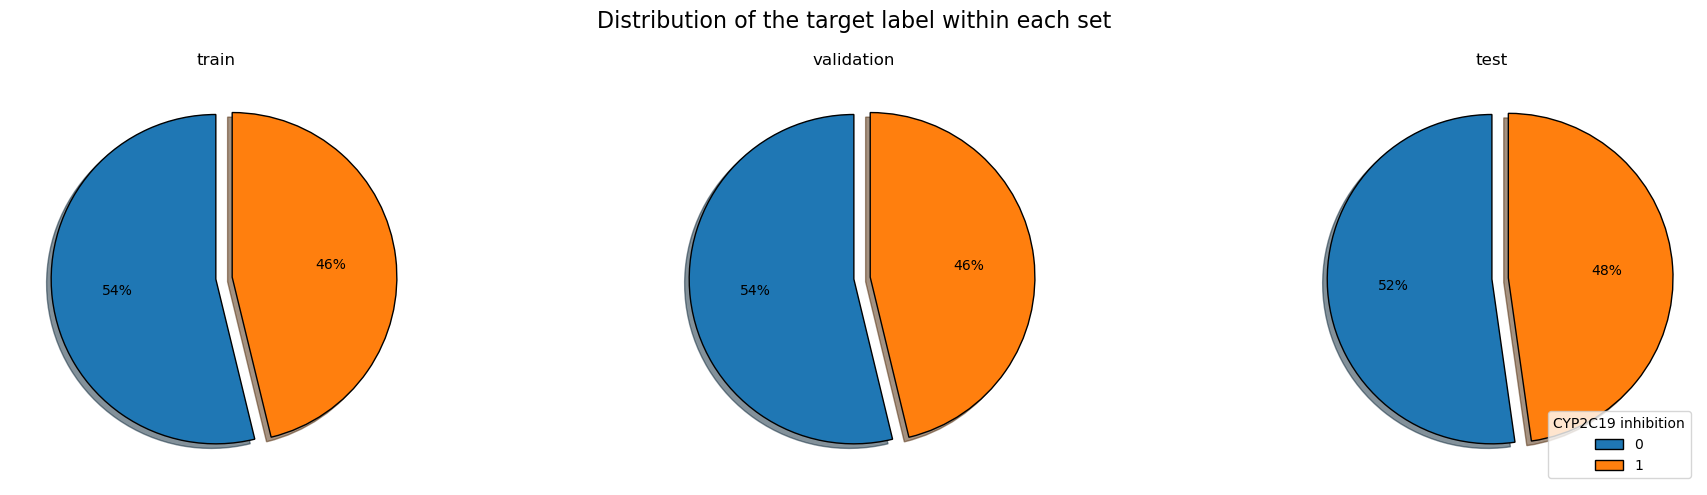

In [8]:
plot_counts(
    [datasets["train"]["Y"], datasets["val"]["Y"], datasets["test"]["Y"]],
    suptitle="Distribution of the target label within each set",
    titles=["train", "validation", "test"],
    legend_title="CYP2C19 inhibition",
    kind="pie",
)

### Continuous Data

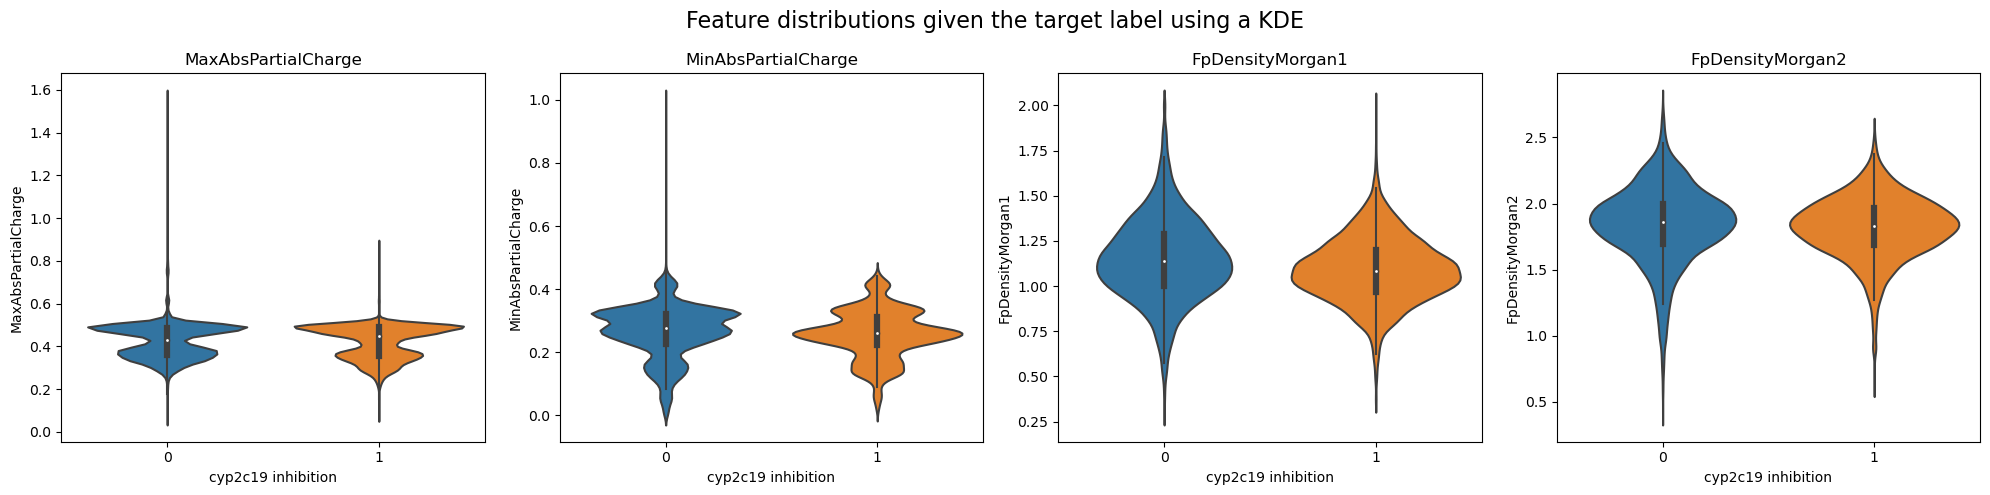

In [9]:
feature_distributions(
    data=datasets["train"][["Y"] + feature_groups.continuous],
    features=feature_groups.continuous[10:14],
    suptitle="Feature distributions given the target label using a KDE",
    task=f"{task} inhibition",
)

In [10]:
# Correlation matrix of descriptors
cor_matrix = datasets["train"][feature_groups.continuous].corr()
top_cor_matrix = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool)
)
fig = px.imshow(
    top_cor_matrix,
    color_continuous_scale="RdBu_r",
    title=f"{task} inhibition\nDescriptor correlation",
)

fig.write_html(f"data/{task.lower()}/descriptor_correlation.html")


### Discrete Data

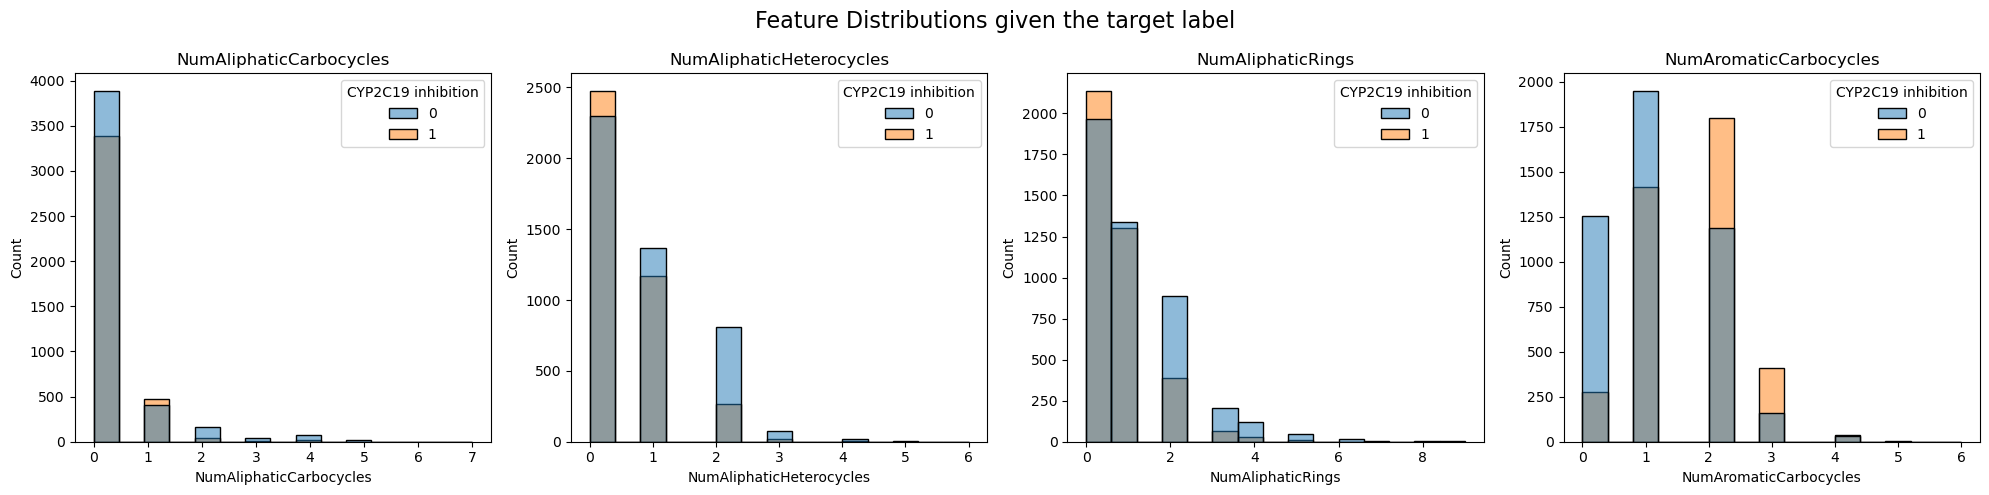

In [11]:
feature_distributions(
    data=datasets["train"][["Y"] + feature_groups.discrete],
    features=feature_groups.discrete[5:9],
    kind="hist",
    suptitle="Feature Distributions given the target label",
    task="CYP2C19 inhibition",
)


## Feature Selection

There are in total 208 different descriptors. Relevant descriptors for the task of predicting CYP inhibition need to be selected to reduce the number of input variables to the clasical machine learning algorithm. Feature selection can either be performed unsupervised (without knowledge of the target label) or supervised.

**Note:** Some machine learning models have some form of feature selection inbuild, e.g. tree-based models. In those cases we don't perform feature selection upfront.

### Variance Threshold

Having a look at for example the number of radical electrons (NumRadicalElectrons). We can see that all datapoints in the dataset have a value of 0 (min=max=0.0). 

In the area of feature selection there is a method called **variance threshold**: Given a threshold all features with a variance below this threshold will be removed. (<span style="color:cyan">TODO</span> Add better source; https://medium.com/nerd-for-tech/removing-constant-variables-feature-selection-463e2d6a30d9#:~:text=Variance%20Threshold%20is%20a%20feature,be%20used%20for%20unsupervised%20learning.)

The default value is usually 0 (removing constant features as they obviously bring no additional information to our model). If the variance threshold is greater than zero but still small we are removing quasi-constant features. The arguments against using a variance greater than 0 say that you may be moving variables that, although they have low variance, might actually be extremely powerful in explaining your target (dependent) variable.

For now, we are exploring which features are constant in our dataset.

In [12]:
print(summarize_descriptors(["NumRadicalElectrons"]))
datasets["train"]["NumRadicalElectrons"].describe()

{'NumRadicalElectrons': 'The number of radical electrons the molecule has (says nothing about spin state)'}


count    8522.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: NumRadicalElectrons, dtype: float64

In [13]:
print("Features with 0 variance:\n")
for index, n_unique in zip(
    datasets["train"].nunique(axis=0).index, datasets["train"].nunique(axis=0)
):
    if n_unique == 1:
        print(index)


Features with 0 variance:

NumRadicalElectrons
SMR_VSA8
SlogP_VSA9
fr_prisulfonamd


### Drop Correlated Features

As shown in the correlation matrix there are some feature groups in our dataset with high correlation. In order to escape the curse of dimensionality we want to remove features with a high correlation to other features - out of two features with high correlation only one remains. When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. Source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

The y-axis of the following dendrogram is a measure of closeness of either individual data points or clusters. 


The idea of dropping highly correlated features is also applied by the following method: [DropCorrelatedFeatures](https://feature-engine.readthedocs.io/en/1.1.x/selection/DropCorrelatedFeatures.html) from the feature_engine. Here, features are removed on first found first removed basis, without any further insight using pearson correlation score.

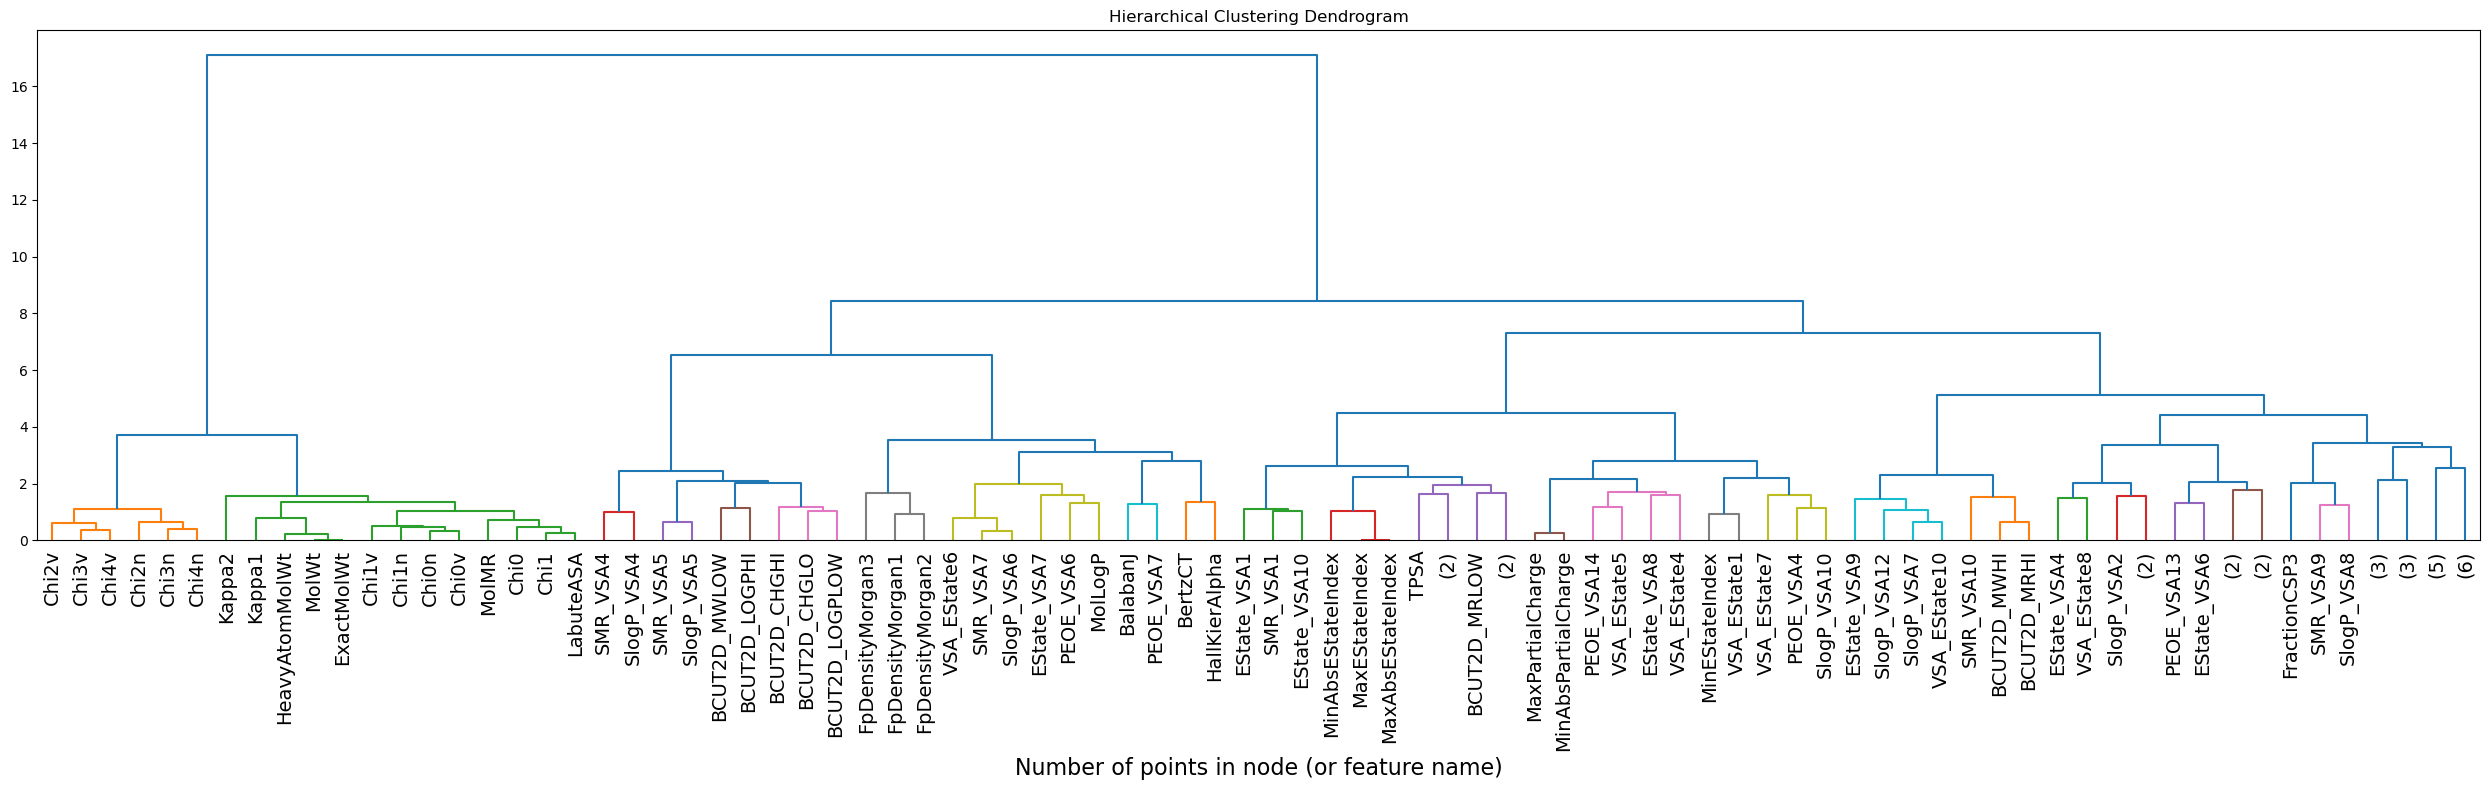

In [14]:
plot_dendrogram(cor_matrix, level=7, color_threshold=2)

In [15]:
# Exploring DropCorrelatedFeatures

drop_corr_features = DropCorrelatedFeatures(threshold=0.8)
print(
    "Number of features before transformation:",
    datasets["train"][feature_groups.continuous].shape[1],
)
reduced_continuous_data = drop_corr_features.fit_transform(
    datasets["train"][feature_groups.continuous]
)
print("Number of features after transformation:", reduced_continuous_data.shape[1])

# Correlation matrix of descriptors
reduced_cor_matrix = reduced_continuous_data.corr()
reduced_top_cor_matrix = reduced_cor_matrix.where(
    np.triu(np.ones(reduced_cor_matrix.shape), k=1).astype(np.bool)
)
fig = px.imshow(
    reduced_top_cor_matrix,
    color_continuous_scale="RdBu_r",
    title=f"{task} inhibition\nDescriptor correlation after dropping highly correlated features",
)

fig.write_html(f"data/{task.lower()}/descriptor_correlation_pruned.html")

Number of features before transformation: 104
Number of features after transformation: 76


### Select Percentile

For discrete features and fingerprints we are using a mutual information statistical test and apply multivariate feature selection.

## Dimensionality reduction

### PCA

For continuous data we will perform a PCA to reduce the dimensionality of the features. Since PCA should only be applied to continuous data we will split our preprocessing pipeline into three parts:

1. Preprocessing of continuous descriptors
2. Preprocessing of discrete descriptors
3. Preprocessing of the fingerprint

See DataPreprocessing in utils/training.py for the exact preprocessing pipelines.

## Feature Normalization

For continuous features we are using StandardScaler as this is assumed by PCA. For discrete descriptors we are using a MinMaxScaler. Since fingerprint features are binary we don't normalize them.

## Training

### Dummy Classifier

Accuracy: 53.78%


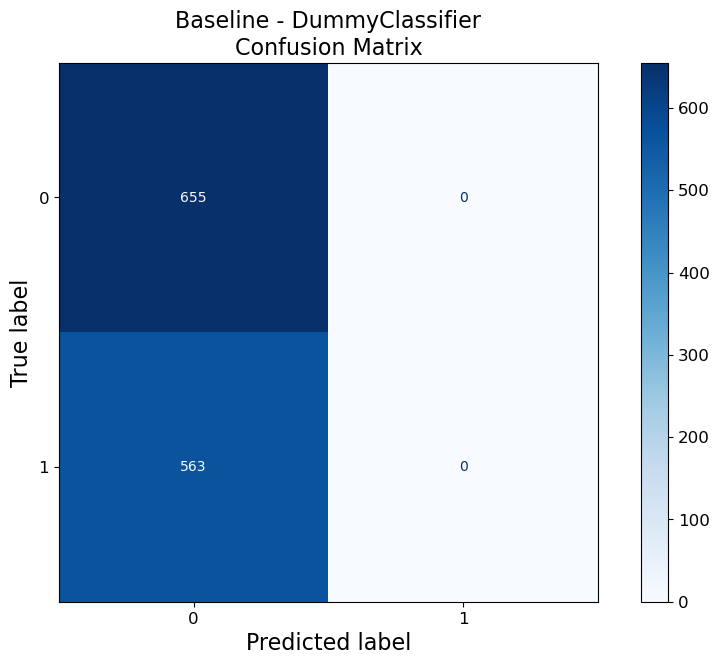

In [16]:
get_baseline(datasets)

### SVC

To keep track of old Bayesian Optimization runs and their differences:

#### SVC_bayesian_0


In [35]:
svc_bayesian_optimizer = BayesianOptimization(
    model=SVC,
    file_name=f"{task}/svc_bayesian_0", 
    model_params=[
        Real(name="C", low=0.1, high=4.0)
    ],
    datasets=datasets,
    feature_groups=feature_groups,
)

# svc_results = svc_bayesian_optimizer.optimize() 

# LOAD results from bayesian optimization
svc_results = pd.read_csv(f"optimization/{task}/svc_bayesian_0").drop("Unnamed: 0", axis=1)

svc_results.sort_values("val_accuracy")

,C,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy
42,2.861239,0.002006,0.044243,0.002372,0.948509,-0.830049
43,1.551426,0.004506,0.040655,0.008003,0.920234,-0.830049
48,1.445894,0.040839,0.048193,0.000731,0.932312,-0.829228
16,1.200976,0.017961,0.008607,0.001157,0.716280,-0.826765
47,1.158980,0.035749,0.046408,0.000007,0.923768,-0.825944
41,1.094109,0.007962,0.027295,0.005071,0.835420,-0.825123
29,1.085444,0.008177,0.015984,0.002762,0.744170,-0.824302
28,1.047559,0.007734,0.001311,0.000420,0.733177,-0.824302
49,0.872567,0.036014,0.040214,0.000542,0.921572,-0.824302
2,1.138431,0.008248,0.045341,0.008996,0.784090,-0.824302


Number of features after preprocessing:             1999/2256
Accuracy: 83.09%


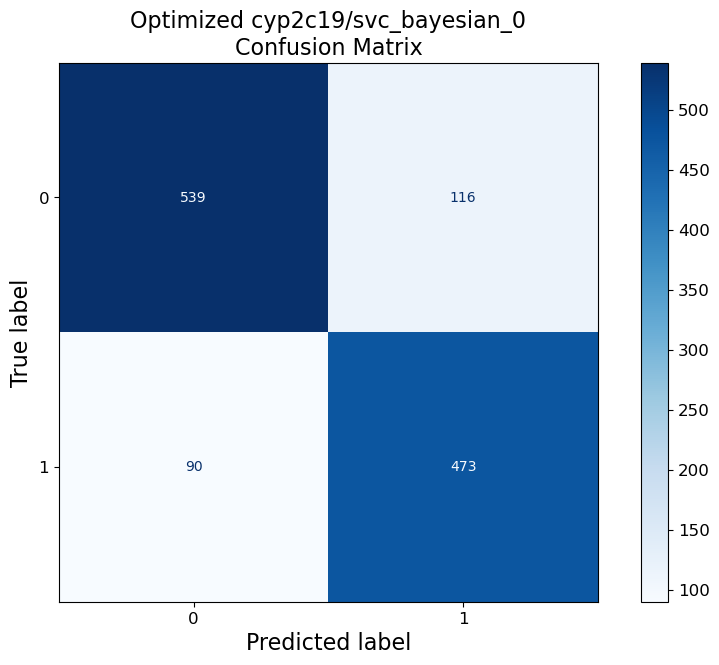

In [36]:
svc_bayesian_optimizer.best_confusion_matrix(svc_results)

#### svc_random_0

We can do random search by setting n_calls = n_initial_points.

In [37]:
svc_bayesian_optimizer = BayesianOptimization(
    model=SVC,
    file_name=f"{task}/svc_random_0", 
    model_params=[
        Real(name="C", low=0.1, high=4.0),
    ],
    datasets=datasets,
    feature_groups=feature_groups,
)

# results = svc_bayesian_optimizer.optimize(n_calls=50, n_initial_points=50) 

# LOAD results from bayesian optimization
# results = load(f"optimization/{task}/svc_random_0")

# svc_bayesian_optimizer.best_confusion_matrix(results)

#### svc_random_1_poly

In [38]:
svc_random_1_poly_optimizer = BayesianOptimization(
    model=SVC,
    file_name=f"{task}/svc_random_1_poly", 
    model_params=[
        Real(name="C", low=0.1, high=4.0),
        Categorical(name="kernel", categories=["poly"]),
        Integer(name="degree", low=3, high=12)
    ],
    datasets=datasets,
    feature_groups=feature_groups,
    preprocessing_params=[
                Categorical(name="var_threshold_continuous", categories=[0.0]),
                Real(name="var_threshold_discrete", low=0.02, high=0.05),
                Categorical(name="var_threshold_fingerprint", categories=[0.0]),
                Real(name="corr_threshold", low=0.7, high=0.95),
            ]
)

# svc_random_1_poly = svc_bayesian_optimizer.optimize(n_calls=50, n_initial_points=50) 

# LOAD results from bayesian optimization
svc_random_1_poly = pd.read_csv(f"optimization/{task}/svc_random_1_poly").drop("Unnamed: 0", axis=1)

svc_random_1_poly.sort_values("val_accuracy")

,C,kernel,degree,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy
1,2.612920,poly,3,0.0,0.027612,0.0,0.95,-0.821839
11,2.700493,poly,3,0.0,0.023544,0.0,0.95,-0.821839
9,2.898647,poly,3,0.0,0.038451,0.0,0.95,-0.821018
3,1.876195,poly,3,0.0,0.039367,0.0,0.95,-0.818555
21,2.301513,poly,3,0.0,0.026999,0.0,0.95,-0.818555
18,1.343519,poly,3,0.0,0.027244,0.0,0.95,-0.815271
14,0.193760,poly,3,0.0,0.037676,0.0,0.95,-0.784072
15,3.153655,poly,5,0.0,0.027970,0.0,0.95,-0.767652
20,2.490935,poly,5,0.0,0.021540,0.0,0.95,-0.763547
24,2.138204,poly,5,0.0,0.026122,0.0,0.95,-0.759442


Number of features after preprocessing:             2208/2256
Accuracy: 83.25%


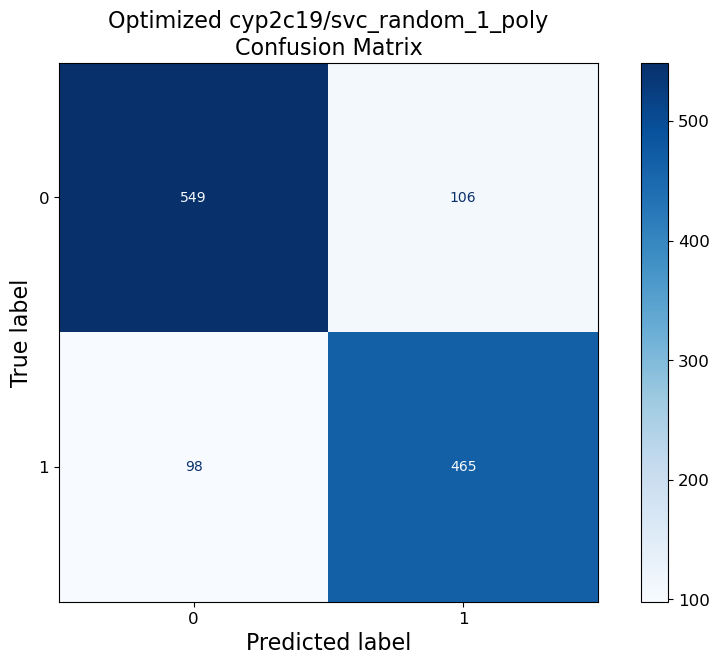

In [39]:
# takes about 2 minutes
svc_random_1_poly_optimizer.best_confusion_matrix(svc_random_1_poly) 

### Weighted SVC
#### svc_weighted_bayesian_0

In [40]:
svc_weighted_bayesian_0_bayesian_optimizer = BayesianOptimization(
    model=SVC,
    file_name=f"{task}/svc_weighted_bayesian_0", 
    model_params=[
        Real(name="C", low=0.1, high=4.0)
    ],
    datasets=datasets,
    feature_groups=feature_groups,
)

# svc_weighted_bayesian_0 = svc_bayesian_optimizer.optimize() 

# LOAD results from bayesian optimization
# svc_weighted_bayesian_0 = pd.read_csv(f"optimization/{task}/svc_weighted_bayesian_0").drop("Unnamed: 0", axis=1)

svc_weighted_bayesian_0.sort_values("val_accuracy")

NameError: name 'svc_weighted_bayesian_0' is not defined

### RandomForestClassifier

For a random forest classifier we don't need to do any preprocessing. A decision tree based classifier is scale variant and has inbuild feature selection.

#### max_depth

turn following cell into python to re-run / edit

In [41]:
def train_random_forest_depth(datasets, file_path):
    if exists(file_path):
        return pd.read_csv(file_path).drop("Unnamed: 0", axis=1)
    x_train = datasets["train"].drop("Y", axis=1)
    y_train = datasets["train"]["Y"]
    x_val = datasets["val"].drop("Y", axis=1)
    y_val = datasets["val"]["Y"]

    preprocessing_pipe = DataPreprocessing(feature_groups, corr_threshold = 1.0)
    preprocessing_pipe.fit(x_train, y_train)
    x_train = preprocessing_pipe.transform(x_train)
    x_val = preprocessing_pipe.transform(x_val)

    metric_names = ["accuracy","f1","precision","recall","mcc","roc_auc_score"]

    with open(file_path, "w") as f:
        f.write(f",max_depth")
        for metric_name in metric_names:
            f.write(f",val_{metric_name}")
        f.write("\n")
        for max_depth in range(3, 60):
            rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
            rf.fit(x_train, y_train)
            y_pred = rf.predict(x_val)
            y_pred_proba = rf.predict_proba(x_val)

            metrics = calculate_metrics(y_val, y_pred, y_pred_proba[:, 1])
            print(
                f"Completed run {max_depth}/{60}: max_depth={max_depth}"
            )
            f.write(f"{max_depth-3}, {max_depth}")
            for metric_value in metrics.values():
                f.write(f",{metric_value}")
            f.write("\n")

    rf_results = pd.read_csv(file_path).drop("Unnamed: 0", axis=1)
    return rf_results


rf_max_depth = train_random_forest_depth(
    datasets=datasets, file_path=f"optimization/{task}/rf_max_depth"
)

In [42]:
rf_max_depth.sort_values("val_accuracy", ascending=False)

,max_depth,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score
22,25,0.811987,0.798593,0.790941,0.806394,0.622437,0.883793
18,21,0.811987,0.799650,0.787931,0.811723,0.622861,0.882511
54,57,0.810345,0.796117,0.791228,0.801066,0.618887,0.884228
52,55,0.810345,0.795756,0.792254,0.799290,0.618772,0.885706
21,24,0.810345,0.798253,0.785223,0.811723,0.619719,0.885027
25,28,0.810345,0.796834,0.789199,0.804618,0.619138,0.883088
24,27,0.810345,0.796834,0.789199,0.804618,0.619138,0.885138
34,37,0.809524,0.795775,0.788831,0.802842,0.617423,0.883281
44,47,0.809524,0.795053,0.790861,0.799290,0.617178,0.881323
14,17,0.809524,0.799655,0.778151,0.822380,0.619243,0.882074


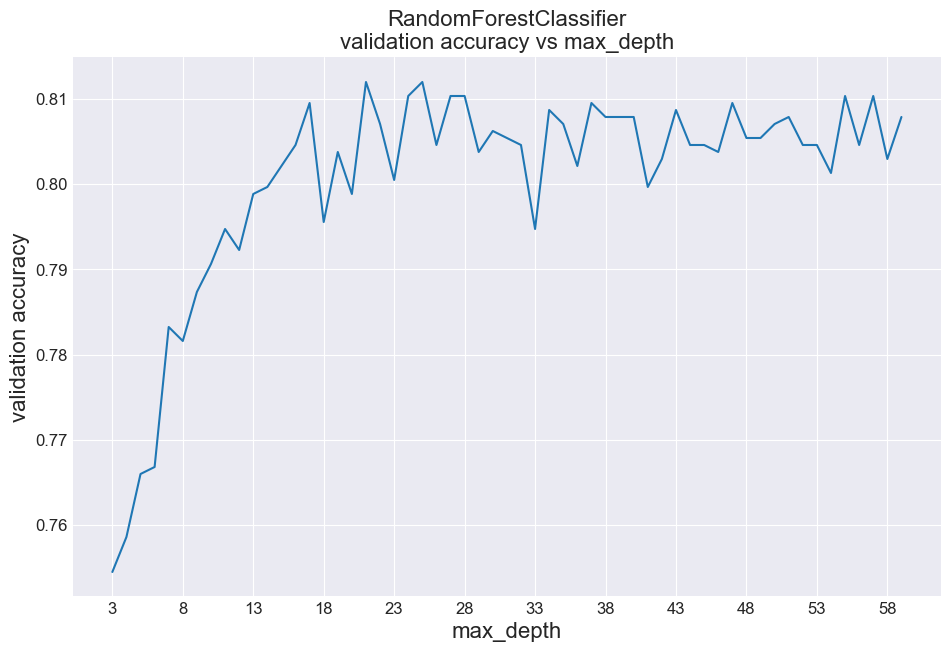

In [43]:
plot_parameter_metric(
    metric_values=rf_max_depth["val_accuracy"],
    model_name="RandomForestClassifier",
    metric="validation accuracy",
    parameter="max_depth",
    param_values=rf_max_depth["max_depth"],
)

Accuracy: 81.28%


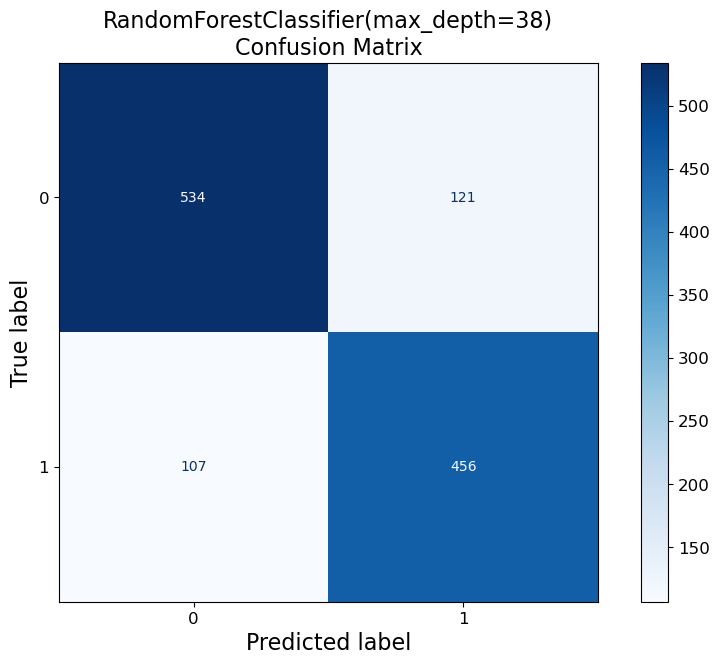

In [44]:
x_train = np.array(datasets["train"].drop("Y", axis=1))
y_train = np.array(datasets["train"]["Y"])
x_val = np.array(datasets["val"].drop("Y", axis=1))
y_val = np.array(datasets["val"]["Y"])

best_rf = RandomForestClassifier(max_depth = int(rf_max_depth.sort_values("val_accuracy", ascending=False).iloc[0]["max_depth"]), n_jobs=-1)
best_rf.fit(x_train, y_train)
y_pred = best_rf.predict(x_val)
confusion_matrix(y_val, y_pred, f"RandomForestClassifier(max_depth=38)")

### Logistic Regression

#### lr_bayesian_0

In [45]:
from sklearn.linear_model import LogisticRegression

lr_bayesian_optimizer = BayesianOptimization(
    model=LogisticRegression,
    file_name=f"{task}/lr_bayesian_0", 
    model_params=[
        Categorical(name="penalty", categories=["l1", "l2"]),
        Real(name="C", low=0.1, high=4.0),
        Categorical(name="solver", categories=["saga"]),
        Categorical(name="n_jobs", categories=[-1])
    ],
    datasets=datasets,
    feature_groups=feature_groups,
)
 
#lr_results = lr_bayesian_optimizer.optimize() 

lr_results = pd.read_csv(f"optimization/{task}/lr_bayesian_0")
lr_results.drop("Unnamed: 0", axis=1).sort_values("val_accuracy")

EmptyDataError: No columns to parse from file

In [46]:
lr_bayesian_optimizer.best_confusion_matrix(lr_results)

NameError: name 'lr_results' is not defined

### CatBoost

#### catboost_random_0

In [47]:
catboost_random_search = BayesianOptimization(
    model=CatBoostClassifier,
    file_name=f"{task}/catboost_random_0", 
    model_params=[],
    fix_model_params={"verbose": 0},
    datasets=datasets,
    feature_groups=feature_groups,
)
 
catboost_random_0 = catboost_random_search.optimize(n_calls=10, n_initial_points=10) 

Iteration No: 1 started. Evaluating function at random point.
Number of features after preprocessing:             1280/2256
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 30.7577
Function value obtained: -0.8161
Current minimum: -0.8161
Iteration No: 2 started. Evaluating function at random point.
Number of features after preprocessing:             332/2256
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 17.0501
Function value obtained: -0.8153
Current minimum: -0.8161
Iteration No: 3 started. Evaluating function at random point.
Number of features after preprocessing:             445/2256
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.0276
Function value obtained: -0.8112
Current minimum: -0.8161
Iteration No: 4 started. Evaluating function at random point.
Number of features after preprocessing:             757/2256
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 27.3102
Function value obtained: -0.8

In [48]:
catboost_random_0

,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score
0,0.008808566833836469,0.04401502815185842,0.01036903713899411,0.9236500778324678,0.8152709359605911,0.8028045574057843,0.7923875432525952,0.8134991119005328,0.6293082548699594,0.8976421298116687
1,0.02192912641694573,0.04926546631740395,0.023975146777032445,0.983891426601188,0.8054187192118226,0.7922874671340929,0.7820069204152249,0.8028419182948491,0.6095217181638989,0.8947866527463291
2,0.024214286387787526,0.03239856587281255,0.03878662252651239,0.9337054839492553,0.8136288998357963,0.8010517090271692,0.7906574394463668,0.8117229129662522,0.6260104987522827,0.8942659959594863
3,0.026811772532302186,0.02145643792982639,0.04543950219081713,0.8138240814335775,0.8169129720853858,0.8062554300608166,0.7891156462585034,0.8241563055062167,0.633406432636123,0.8959201659593508
4,0.005604243100015611,0.019023404129020132,0.018559763338761078,0.849914107063699,0.8078817733990148,0.7958115183246073,0.7821612349914236,0.8099467140319716,0.6148542737353897,0.8948408878282916
5,0.03876182035082284,0.006177493463102458,0.01107449983388157,0.8007567769222185,0.8169129720853858,0.8048993875765529,0.7931034482758621,0.8170515097690941,0.6327524802038647,0.8969452090084471
6,0.010598254528333725,0.04572425939278183,0.009218166418485548,0.8832646572180878,0.812807881773399,0.7996485061511424,0.7913043478260869,0.8081705150976909,0.6241525131773247,0.8941222729922849
7,0.022247300984774725,0.028055537018438447,0.04708542359161191,0.9329133548908026,0.8136288998357963,0.8007023705004389,0.7916666666666666,0.8099467140319716,0.6258696984805137,0.8944720892709449
8,0.048848835903317636,0.027768820807209715,0.021207979310938967,0.8581497232803857,0.8045977011494253,0.7908611599297013,0.782608695652174,0.7992895204262878,0.6076593849138143,0.8960069420904913
9,0.01740099503610071,0.02046419113899384,0.0492914634775497,0.9901622396127209,0.8136288998357963,0.8010517090271692,0.7906574394463668,0.8117229129662522,0.6260104987522827,0.8926525022710939


In [17]:
naive_bayes_optimizer = BayesianOptimization(
    model = GaussianNB,
    file_name=f"{task}/naive_bayes_0",
    model_params=[],
    datasets=datasets,
    feature_groups=feature_groups,
    preprocessing_params=None
)
              
naive_bayes_0 = naive_bayes_optimizer.optimize()

# LOAD results from bayesian optimization
naive_bayes_0 = pd.read_csv(f"optimization/{task}/naive_bayes_0").drop("Unnamed: 0", axis=1)

naive_bayes_0.sort_values("val_accuracy")

Iteration No: 1 started. Evaluating function at random point.
Number of features after preprocessing:             363/2256
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7799
Function value obtained: -0.7397
Current minimum: -0.7397
Iteration No: 2 started. Evaluating function at random point.
Number of features after preprocessing:             635/2256
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.9584
Function value obtained: -0.7373
Current minimum: -0.7397
Iteration No: 3 started. Evaluating function at random point.
Number of features after preprocessing:             708/2256
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0724
Function value obtained: -0.7381
Current minimum: -0.7397
Iteration No: 4 started. Evaluating function at random point.
Number of features after preprocessing:             1464/2256
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.2048
Function value obtained: -0.7594


Number of features after preprocessing:             1569/2256
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.5842
Function value obtained: -0.7603
Current minimum: -0.7644
Iteration No: 33 started. Searching for the next optimal point.
Number of features after preprocessing:             1433/2256
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.5468
Function value obtained: -0.7578
Current minimum: -0.7644
Iteration No: 34 started. Searching for the next optimal point.
Number of features after preprocessing:             905/2256
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.3146
Function value obtained: -0.7414
Current minimum: -0.7644
Iteration No: 35 started. Searching for the next optimal point.
Number of features after preprocessing:             1568/2256
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.5604
Function value obtained: -0.7644
Curren

,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score
7,0.007627,0.037843,0.042495,0.904238,0.732348,0.747287,0.662999,0.856128,0.489991,0.806615
9,0.015060,0.043093,0.043001,0.837798,0.733990,0.748837,0.664374,0.857904,0.493348,0.811583
1,0.019978,0.008970,0.017107,0.851552,0.737274,0.746434,0.673820,0.836590,0.492510,0.798820
2,0.007076,0.008177,0.014973,0.937212,0.738095,0.745817,0.676301,0.831261,0.492474,0.797075
4,0.021674,0.049908,0.011839,0.963533,0.738916,0.746411,0.677279,0.831261,0.493899,0.793421
0,0.029612,0.001252,0.040139,0.946781,0.739737,0.755966,0.667120,0.872114,0.507810,0.799649
33,0.041209,0.049053,0.010074,0.952735,0.741379,0.746581,0.682353,0.824156,0.496358,0.790594
6,0.001220,0.015371,0.032679,0.848185,0.741379,0.755245,0.671271,0.863233,0.507578,0.808253
14,0.013554,0.042255,0.000912,0.877994,0.743842,0.738255,0.699523,0.781528,0.491835,0.779115
29,0.024371,0.001248,0.007660,0.834872,0.744663,0.750201,0.684751,0.829485,0.503439,0.788417


In [19]:
knn_optimizer = BayesianOptimization(
    model=KNeighborsClassifier,
    file_name=f"{task}/knn_0", 
    model_params=[
        Categorical(name="n_neighbors", categories=[9, 10, 11, 12]),
        Categorical(name="algorithm", categories=["auto", "ball_tree", "kd_tree", "brute"]),
        Categorical(name="leaf_size", categories=[5, 10, 20, 30, 50]),
        Categorical(name="p", categories=[1, 3, 5]),
    ],
    datasets=datasets,
    feature_groups=feature_groups,
    preprocessing_params=None
)

knn_0 = knn_optimizer.optimize(n_calls=10)

# LOAD results from bayesian optimization
knn_0 = pd.read_csv(f"optimization/{task}/knn_0").drop("Unnamed: 0", axis=1)
knn_0.sort_values("val_accuracy")

Iteration No: 1 started. Evaluating function at random point.
Number of features after preprocessing:             603/2256
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 22.5646
Function value obtained: -0.7660
Current minimum: -0.7660
Iteration No: 2 started. Evaluating function at random point.
Number of features after preprocessing:             495/2256
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.7250
Function value obtained: -0.7291
Current minimum: -0.7660
Iteration No: 3 started. Evaluating function at random point.
Number of features after preprocessing:             802/2256
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 42.0577
Function value obtained: -0.7151
Current minimum: -0.7660
Iteration No: 4 started. Evaluating function at random point.
Number of features after preprocessing:             479/2256
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 22.3061
Function value obtained: -0.77

,n_neighbors,algorithm,leaf_size,p,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score
15,12,ball_tree,50,3,0.038197648274340926,0.01582944573649104,0.0058195437500748026,0.9633549472927105,0.69376026272578,0.5717566016073479,0.8084415584415584,0.4422735346358792,0.40398448878234083,0.828924925087793
2,10,ball_tree,20,3,0.01139013857709872,0.027355482351648853,0.005011891149941695,0.9429318919903573,0.7044334975369458,0.5899772209567199,0.8222222222222222,0.46003552397868563,0.4264549277575887,0.8329464564153322
0,12,kd_tree,50,3,0.01191438112125077,0.03916764447033202,0.00773608608548237,0.9798341440977725,0.7068965517241379,0.5947786606129398,0.8238993710691824,0.46536412078152756,0.4311939627511824,0.8338386235136198
17,12,brute,50,3,0.022665902943297477,0.0005600979536412866,0.012574068680524072,0.9664937628943673,0.7093596059113301,0.6040268456375839,0.8157099697885196,0.47957371225577267,0.43309736689952216,0.8381421772673654
13,12,auto,10,3,0.0456584523755515,0.016815611555559815,0.012683241064672298,0.9703865904896882,0.7151067323481116,0.6122905027932961,0.8253012048192772,0.4866785079928952,0.44577184747374615,0.8370439168576194
7,12,ball_tree,20,3,0.04885679651602073,0.02787314958400064,0.04888018946740289,0.8269454448864806,0.7233169129720853,0.64859228362878,0.7853535353535354,0.5523978685612788,0.44983004296966755,0.8330088267595894
12,12,brute,20,3,0.007922906993935375,0.01361397426078417,0.023875142651141462,0.8353662433946424,0.729064039408867,0.6443965517241379,0.8191780821917808,0.5310834813499112,0.4683230727556129,0.8407644434802652
5,11,kd_tree,5,5,0.04875553831442899,0.007901129605349529,0.028741766184590345,0.8427924395604888,0.7348111658456487,0.6652849740932641,0.7985074626865671,0.5701598579040853,0.4734063260544625,0.833762694398872
4,11,brute,5,5,0.007862969625320234,0.022315587498539305,0.036748062689709225,0.8801031296096289,0.7380952380952381,0.6774519716885743,0.7863849765258216,0.5950266429840142,0.47682947919800406,0.8345002915135655
9,9,auto,10,5,0.046931513537446186,0.02845380743853267,0.034080370816994554,0.8943939019698075,0.7397372742200329,0.6833166833166834,0.7808219178082192,0.6074600355239786,0.4788424331433756,0.8350751833823709


In [21]:
xgboost_optimizer = BayesianOptimization(
    model=XGBClassifier,
    file_name=f"{task}/xgboost_0", 
    model_params=[
        Categorical(name="max_depth", categories=[10, 20, 30, 50, 100]),
        Categorical(name="objective", categories=["binary:logistic"]),
        Real(name="colsample_bytree", low=0.01, high=1),
        Real(name="subsample", low=0.01, high=1),
        Categorical(name="n_estimators", categories=[100, 500, 1000, 3000, 5000, 10000]),
        Real(name="learning_rate", low=0.001, high=0.5),
        Real(name="gamma", low=0, high=2),
    ],
    datasets=datasets,
    feature_groups=feature_groups,
)

xgboost_0 = xgboost_optimizer.optimize(n_calls=50)

# LOAD results from bayesian optimization
xgboost_0 = pd.read_csv(f"optimization/{task}/xgboost_0").drop("Unnamed: 0", axis=1)
xgboost_0.sort_values("val_accuracy")

Iteration No: 1 started. Evaluating function at random point.
Number of features after preprocessing:             499/2256
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 601.4932
Function value obtained: -0.8079
Current minimum: -0.8079
Iteration No: 2 started. Evaluating function at random point.
Number of features after preprocessing:             1134/2256
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.7385
Function value obtained: -0.7603
Current minimum: -0.8079
Iteration No: 3 started. Evaluating function at random point.
Number of features after preprocessing:             404/2256
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.6094
Function value obtained: -0.7841
Current minimum: -0.8079
Iteration No: 4 started. Evaluating function at random point.
Number of features after preprocessing:             316/2256
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.5782
Function value obtained: -0.687

Number of features after preprocessing:             305/2256
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 7.6016
Function value obtained: -0.8030
Current minimum: -0.8259
Iteration No: 33 started. Searching for the next optimal point.
Number of features after preprocessing:             673/2256
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 338.5919
Function value obtained: -0.7906
Current minimum: -0.8259
Iteration No: 34 started. Searching for the next optimal point.
Number of features after preprocessing:             291/2256
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 481.4261
Function value obtained: -0.8144
Current minimum: -0.8259
Iteration No: 35 started. Searching for the next optimal point.
Number of features after preprocessing:             319/2256
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 52.6034
Function value obtained: -0.7931
Curr

,max_depth,objective,colsample_bytree,subsample,n_estimators,learning_rate,gamma,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score
104,10,binary:logistic,0.10018782458946679,0.03256974414057413,100,0.38078489577823427,0.27331865711352804,0.02866854010179077,0.023411703570135788,0.044777234157724805,0.8942229607565895,0.687192118226601,0.6773920406435225,0.6472491909385113,0.7104795737122558,0.37661740948317723,0.7546608273561753
140,20,binary:logistic,0.6826784194062504,0.013825942114980538,100,0.1006578932968606,0.02082387406043629,0.0020219598647426788,0.028121215344317614,0.038402837985162364,0.8667316376176387,0.7430213464696224,0.7256792287467134,0.7162629757785467,0.7353463587921847,0.48420698569218174,0.8211679524900684
123,10,binary:logistic,0.7449854305110254,0.1261998513892582,5000,0.3237655091458008,0.7046532929451198,0.0050742639879497245,0.011962166423175704,0.020227303180714105,0.8994067545396678,0.7454844006568144,0.7261484098939929,0.7223198594024605,0.7300177619893428,0.4884547685469386,0.8283649478665275
130,20,binary:logistic,0.5033937313151166,0.365464982680344,100,0.3648273303378836,0.2846603907015904,0.030095044794991747,0.019378200379483554,0.046536045760631535,0.9833456955741045,0.7561576354679803,0.7374005305039788,0.7341549295774648,0.7406749555950266,0.5098399861310681,0.8420281208899977
131,10,binary:logistic,0.514114365917036,0.028295397435248497,100,0.12316185546252778,1.9623429993131014,0.03005071807463745,0.004299769860259401,0.046288823962215446,0.9547530680857682,0.7561576354679803,0.7383259911894272,0.7325174825174825,0.7442273534635879,0.5101231553769628,0.8322522473662088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,25,binary:logistic,0.149289458265646,0.9284207673872578,1000,0.027549381519535145,0.7026658028036005,0.04215821615843033,0.0014302891263870134,0.011447525834374386,0.815259896856766,0.825944170771757,0.8153310104529617,0.8,0.8312611012433393,0.6512766651889814,0.9005491302048729
86,25,binary:logistic,0.49559409533831544,0.9221574639435955,1000,0.017365348655650068,0.2670977425710655,0.047780151053865794,0.001670925046275057,0.017133270879761613,0.8694788612010151,0.8275862068965517,0.8157894736842105,0.8058925476603119,0.8259325044404974,0.6539725704100317,0.8959906715659024
69,10,binary:logistic,0.1434693639630769,0.3186221760716194,1000,0.059663360843638165,1.8525636366584624,0.03950339107071446,0.009282663211051036,0.008471248637368202,0.8284221705968937,0.8275862068965517,0.8180242634315424,0.7986463620981388,0.8383658969804618,0.655096727429696,0.896920803221564
38,30,binary:logistic,0.9265050967095738,0.3735024938618283,1000,0.022729409609835185,1.790666114575905,0.03835857188821403,0.002753225886939576,0.009174332452345776,0.8212782411199016,0.8300492610837439,0.8188976377952756,0.8068965517241379,0.8312611012433393,0.6591302510907752,0.8976367063034725


In [ ]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(datasets["train"])
#profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

# Next Steps

- ~~Use Dendrogram [only continuous data] for feature selection (Jonna)~~
- Feature selection method for discrete data (James)
- ~~Baseline~~
  - ~~DummyClassifier~~
- Classical models
  - ~~Random Forest (little feature selection) (Jonna)~~
  - ~~KNN + Bayesian Optimization (James)~~
  - ~~XGBoost + Bayesian Optimization (James)~~
  - ~~SVC (Jonna)~~
  - Linear Models (Jonna)
  - ~~Naive Bayes + Bayesian Optimization (James)~~
  - [later] simple NN
- Try giving weights to classes (will solve unbalanced data sets)
- Get report working (James)
- ~~Bayesian Optimization (Jonna)~~
- apply the notebook to the other datasets


**Metrics** 

- measure similarity between train, val, and test
- (she) Rosio post-doc as AZ
- mathews correlation coefficient (btw. -1, 1 validation) - different than f1 score
- ROC curve (get maximum)
- XGBoost: CatBoost
- Bayesian Optimization / Random Search 

- confusion matrix